# 1. Implementing your own Shazam

In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

In [2]:
from AudioSignals import *

### Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

### Preprocessing

In [4]:
track_conversion()

  0%|          | 0/1413 [00:00<?, ?it/s]

### Audio signals

In [9]:
tracks = retrieve_tracks()

In [14]:
onset_env[peaks]

array([14.29508  ,  3.381905 , 14.321033 ,  3.4989123,  4.321933 ,
        6.33145  , 10.507294 ,  3.9664576, 12.847541 ,  3.5759244,
        5.738647 ,  3.2718804,  4.8260455,  3.788729 , 16.246567 ,
        3.8096871,  7.497882 ,  7.8256693,  7.66502  ,  3.3945165,
       10.647072 ,  3.283933 ,  6.755358 ,  7.654502 ,  7.633061 ,
        2.26175  ,  2.9022884,  4.5343657,  4.1645913,  2.5920973,
        4.9498534,  2.5749815,  3.7579563,  2.6921985,  3.9555871,
        4.7122097,  4.8172116,  6.3849454,  3.413362 ,  5.3490324,
        9.657435 ,  5.2067294,  8.888061 ,  4.756869 ,  5.767321 ,
        4.5388937,  3.488101 ,  4.5300317,  7.4172883,  5.4374256,
        2.6979067,  4.0343566,  3.9446762,  4.613406 ,  4.2632074,
        2.4404025,  2.9190114], dtype=float32)

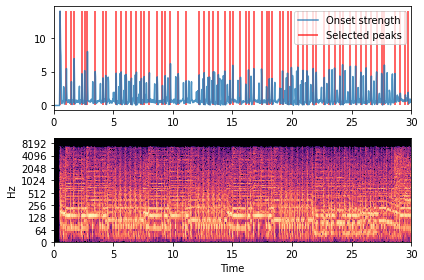

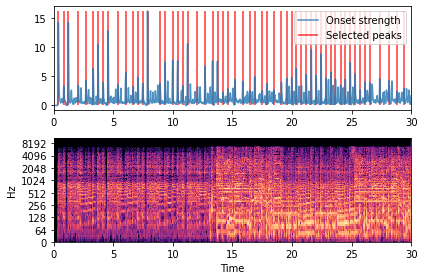

In [10]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        

### Minhash

In [ ]:
#prova


# 3. ALGORITHMIC QUESTION

## 3. Algorithmic questions

You are given a list of integers, *A*, and another integer *s*. Write an algorithm that outputs all the pairs in *A* that equal *x*.

For example, if
```
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
```
the algorithm should output: `(7, -3), (-2, 6), (2, 2), (3, 1)`.

The running time of the algotith is proportional to $ n^2 $ since <br><br> $ =\sum_{i=1}^n (n-i-1) $ <br> <br> $ =\sum_{i=1}^{n} n - \sum_{i=1}^{n} i -\sum_{i=1}^{n} i $ <br><br> = $n^2 - \frac{n(n+1)}{2}-n $ <br><br> $= \frac{n^2}{2}-\frac{3n}{2} $ <br><br> $ \propto n^2 $

In [7]:
def algoritmo(A,s):
    result=[]
    for i in range(len(A)):
        j=i+1
        while j<len(A):
            if A[i]+A[j]==s:
                result.append((A[i],A[j]))
            j+=1
    print(result)

In [8]:
algoritmo([7,-2,8,2,6,4,-7,2,1,3,-3],4)

[(7, -3), (-2, 6), (2, 2), (1, 3)]
